# Alpaca Recognition

<a target="_blank" href="https://colab.research.google.com/github/LuisAngelMendozaVelasco/luisangelmendozavelasco.github.io/blob/master/_portfolio/Deep_Learning_Specialization/portfolio-3.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a>

**Objective**: Implement transfer learning using a pretrained Convolutional Neural Network to build an alpaca classifier.

## Import libraries

In [1]:
import tensorflow as tf
from datetime import datetime
from keras import applications, Sequential, layers, Input, Model, callbacks
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

2025-01-04 12:10:58.710549: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736014258.734816   84280 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736014258.746172   84280 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-04 12:10:58.772530: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Download the dataset

In [2]:
%%bash

if [ -e "/tmp/Alpaca_NotAlpaca.zip" ]; then
    echo "Alpaca_NotAlpaca.zip already exists!"
else
    gdown 13JG3cmbMT2bzCxP4mqs_2KwsqPRYyfpc -O /tmp/
fi

unzip -qn /tmp/Alpaca_NotAlpaca.zip -d /tmp

Alpaca_NotAlpaca.zip already exists!


## Load the dataset

In [3]:
def get_file_paths(path):
    file_paths = []

    for file in os.listdir(path):
        if file.endswith(".jpg"):
            file_paths.append(os.path.join(path, file))
    
    return file_paths

def load_image(file_path, image_size):
    image = tf.io.read_file(file_path)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_size)
    
    return image

In [4]:
alpaca_file_paths = get_file_paths("/tmp/Alpaca_NotAlpaca/alpaca")
nonalpaca_file_paths = get_file_paths("/tmp/Alpaca_NotAlpaca/not alpaca")
file_paths = alpaca_file_paths + nonalpaca_file_paths

X = np.array(list(map(lambda x: load_image(x, (160, 160)), file_paths)))
y = np.array([1] * len(alpaca_file_paths) + [0] * len(nonalpaca_file_paths))

X_train, X_right, y_train, y_right = train_test_split(X, y, test_size=0.2, random_state=0)
X_test, X_validation, y_test, y_validation = train_test_split(X_right, y_right, test_size=0.5, random_state=0)

ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
ds_validation = tf.data.Dataset.from_tensor_slices((X_validation, y_validation)).batch(32)
classes = ["non-alpaca", "alpaca"]

I0000 00:00:1736014262.706869   84280 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1662 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


In [5]:
print("Number of training samples:", X_train.shape[0])
print("Number of validation samples:", X_validation.shape[0])
print("Number of test samples:", X_test.shape[0])
print("Each image has a shape of", X_train.shape[1:])

Number of training samples: 261
Number of validation samples: 33
Number of test samples: 33
Each image has a shape of (160, 160, 3)


## Visualize the dataset

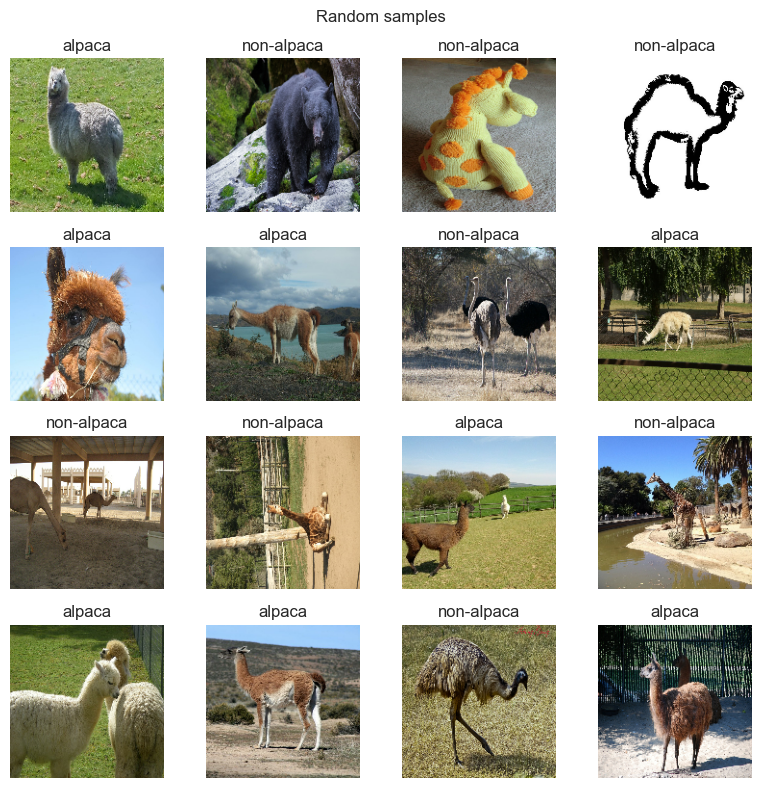

In [6]:
indexes = np.random.choice(range(0, X_train.shape[0]), size=16, replace=False)
samples = zip(X_train[indexes], y_train[indexes])

fig, axs = plt.subplots(4, 4, figsize=(8, 8))
fig.suptitle('Random samples')

for ax, sample in zip(axs.flatten(), samples):
    ax.imshow(sample[0] / 255)
    ax.set_title(classes[sample[1]])
    ax.axis("off")

plt.tight_layout()
plt.show()

## Visualize the class distribution

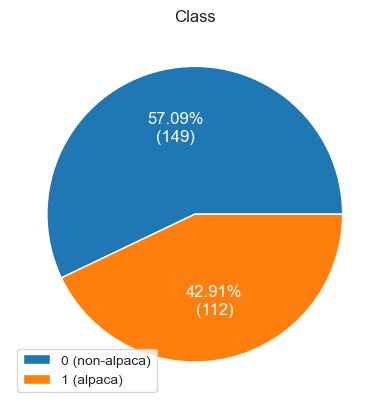

In [7]:
labels, sizes = np.unique(y_train, return_counts=True)

fig, ax = plt.subplots()
ax.pie(sizes, textprops={'color': "w", 'fontsize': '12'}, autopct=lambda pct: "{:.2f}%\n({:d})".format(pct, round(pct/100 * sum(sizes))))
ax.legend(["1 (alpaca)" if label else "0 (non-alpaca)" for label in labels])
ax.set_title("Class")
plt.show()

## Build a Convolutional Neural Network using the MobileNetV2 architecture as a base

In [8]:
MobileNetV2 = applications.MobileNetV2(include_top=False, input_shape=(160, 160, 3))
MobileNetV2.trainable = False

data_augmentation = Sequential([layers.RandomFlip(mode="horizontal"),
                                layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode="nearest"),
                                layers.RandomRotation(factor=0.2, fill_mode="nearest"),
                                layers.RandomZoom(height_factor=0.2, width_factor=0.2, fill_mode="nearest")])

inputs = Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = applications.mobilenet_v2.preprocess_input(x)
x = MobileNetV2(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = Model(inputs, outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Create a custom callback

In [9]:
class CustomVerbose(callbacks.Callback):
    def __init__(self, epochs_to_show):
        self.epochs_to_show = epochs_to_show

    def on_epoch_begin(self, epoch, logs=None):
        if epoch in self.epochs_to_show:
            self.epoch_start_time = datetime.now()

    def on_epoch_end(self, epoch, logs=None):
        if epoch in self.epochs_to_show:
            self.epoch_stop_time = datetime.now()
            print(f"Epoch {epoch+1}/{self.epochs_to_show[-1] + 1}")
            print(f"\telapsed time: {(self.epoch_stop_time - self.epoch_start_time).total_seconds():.3f}s - accuracy: {logs['binary_accuracy']:.4f} - loss: {logs['loss']:.4f} - val_accuracy: {logs['val_binary_accuracy']:.4f} - val_loss: {logs['val_loss']:.4f}")

## Compile and train the model

In [10]:
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['binary_accuracy'])

epochs = 200
epochs_to_show = [0] + [i for i in range(int(epochs/10)-1, epochs, int(epochs/10))]
custom_verbose = CustomVerbose(epochs_to_show)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=int(epochs/10), verbose=1)
history = model.fit(ds_train, epochs=epochs, verbose=0, validation_data=ds_validation, callbacks=[custom_verbose, early_stopping])

I0000 00:00:1736014278.397286   84376 cuda_dnn.cc:529] Loaded cuDNN version 90300


Epoch 1/200
	elapsed time: 12.561s - accuracy: 0.5402 - loss: 0.7419 - val_accuracy: 0.5758 - val_loss: 0.8325
Epoch 20/200
	elapsed time: 0.471s - accuracy: 0.8851 - loss: 0.2862 - val_accuracy: 0.8788 - val_loss: 0.2612
Epoch 40/200
	elapsed time: 0.464s - accuracy: 0.9234 - loss: 0.2102 - val_accuracy: 0.9697 - val_loss: 0.1751
Epoch 60/200
	elapsed time: 0.461s - accuracy: 0.9310 - loss: 0.1844 - val_accuracy: 0.9697 - val_loss: 0.1476
Epoch 80/200
	elapsed time: 0.465s - accuracy: 0.9502 - loss: 0.1415 - val_accuracy: 0.9697 - val_loss: 0.1235
Epoch 100/200
	elapsed time: 0.464s - accuracy: 0.9732 - loss: 0.1138 - val_accuracy: 0.9697 - val_loss: 0.1126
Epoch 120/200
	elapsed time: 0.463s - accuracy: 0.9387 - loss: 0.1287 - val_accuracy: 0.9394 - val_loss: 0.1142
Epoch 136: early stopping


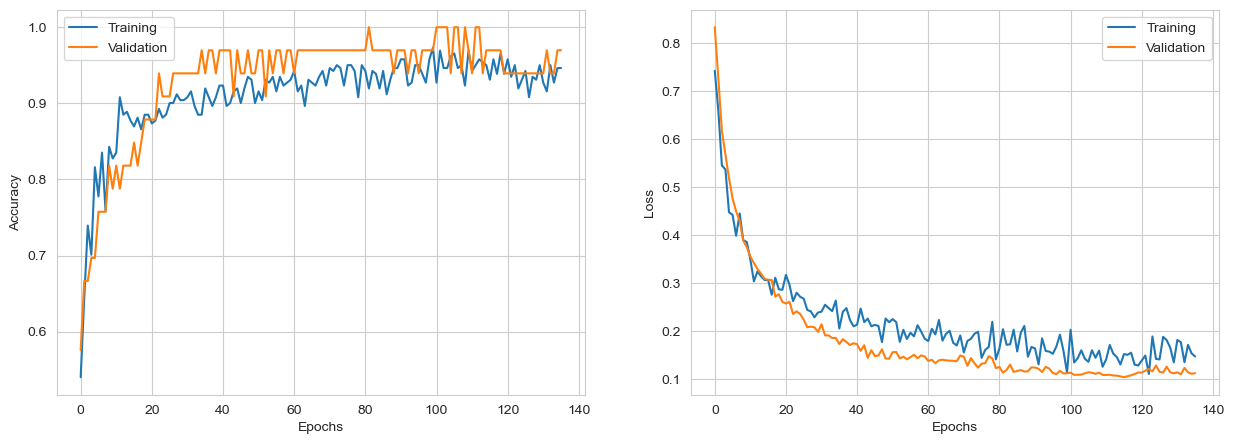

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history.history['binary_accuracy'])
ax1.plot(history.history['val_binary_accuracy'])
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.legend(["Training", "Validation"])

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.legend(["Training", "Validation"])

plt.show()

## Evaluate the model

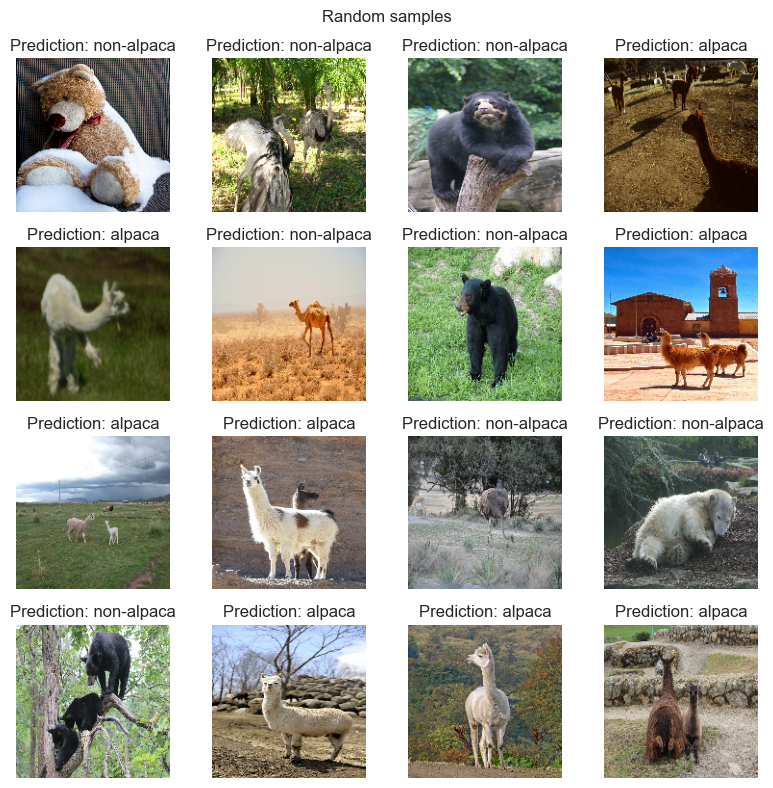

In [12]:
indexes = np.random.choice(range(0, X_test.shape[0]), size=16, replace=False)

fig, axs = plt.subplots(4, 4, figsize=(8, 8))
fig.suptitle('Random samples')

for image, ax in zip(X_test[indexes], axs.flatten()):
    prediction_proba = model.predict(np.expand_dims(image, axis=0), verbose=0)
    ax.imshow(image / 255)
    ax.set_title("Prediction: " + classes[int(prediction_proba.squeeze().round())])
    ax.axis("off")

plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

           0     0.9375    1.0000    0.9677        15
           1     1.0000    0.9444    0.9714        18

    accuracy                         0.9697        33
   macro avg     0.9688    0.9722    0.9696        33
weighted avg     0.9716    0.9697    0.9698        33



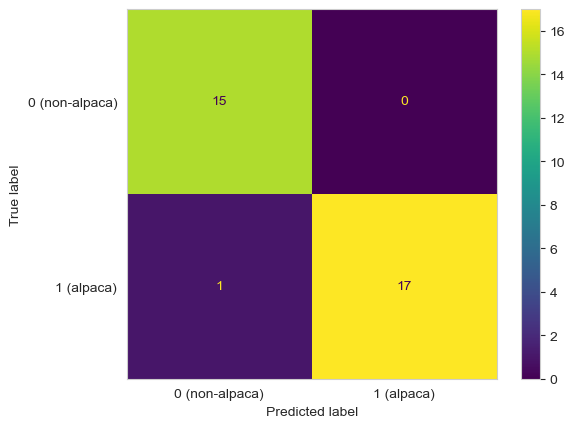

In [13]:
y_pred = []

for image in X_test:
    prediction_proba = model.predict(np.expand_dims(image, axis=0), verbose=0)
    y_pred.append(int(prediction_proba.squeeze().round()))

print(classification_report(y_test, y_pred, digits=4))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["0 (non-alpaca)", "1 (alpaca)"])
plt.grid(False)
plt.show()